In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

sys.path.append("..")

In [3]:
import numpy as np
import pandas as pd
import random

from librep.utils.dataset import load_full_data, PandasDatasetsIO

from librep.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from librep.estimators import RandomForestClassifier
from librep.base.data import Dataset
from librep.base.transform import Transform

from librep.datasets.motionsense import MotionSenseDataset
from librep.datasets.kuhar import KuHarDataset

from librep.utils.visualization import visualize_sample_windowed
from librep.transforms import FFT, SimpleResampler, StatsTransform
from librep.utils.transform import TransformDataset, WindowedTransform

# Utilitary functions

In [4]:
def transform_datasets(
    transformer: TransformDataset, train: Dataset, validation: Dataset, test: Dataset
):
    new_train = transformer(train)
    new_validation = transformer(validation)
    new_test = transformer(test)
    return new_train, new_validation, new_test

class IdentityTransform(Transform):
    def fit(self, X, y):
        pass
    
    def transform(self, X):
        return X

class DatasetBuilder:
    def __init__(
        self,
        dataset_cls: type,
        sensors: list,
        label_columns="activity code",
        as_array: bool = True,
    ):
        self.dataset_cls = dataset_cls
        self.sensors = sensors
        self.label_columns = label_columns
        self.as_array = as_array

    def __call__(self, train, validation, test):
        train_ds = self.dataset_cls(
            train,
            sensors=self.sensors,
            label_columns=self.label_columns,
            as_array=self.as_array,
        )
        validation_ds = self.dataset_cls(
            validation,
            sensors=self.sensors,
            label_columns=self.label_columns,
            as_array=self.as_array,
        )
        test_ds = self.dataset_cls(
            test,
            sensors=self.sensors,
            label_columns=self.label_columns,
            as_array=self.as_array,
        )
        return train_ds, validation_ds, test_ds


activity_names = {0: "dws", 1: "ups", 2: "sit", 3: "std", 4: "wlk", 5: "jog"}

# Loading datasets

## MotionSense

In [5]:
motionsense_dataset_path = Path("../data/views/MotionSense/balanced_view")
ms_train_df, ms_validation_df, ms_test_df = PandasDatasetsIO(
    motionsense_dataset_path).load()

ms_train_dataset, ms_validation_dataset, ms_test_dataset = DatasetBuilder(
    dataset_cls=MotionSenseDataset,
    sensors=["userAcceleration", "rotationRate"],
    label_columns="activity code",
    as_array=True,
)(ms_train_df, ms_validation_df, ms_test_df)

ms_train_dataset[0][0].shape

(900,)

## KuHar

In [6]:
kuhar_dataset_path = Path("../data/views/KuHar/balanced_motionsense_equivalent_view")
kh_train_df, kh_validation_df, kh_test_df = PandasDatasetsIO(kuhar_dataset_path).load()

kh_train_dataset, kh_validation_dataset, kh_test_dataset = DatasetBuilder(
    dataset_cls=MotionSenseDataset,
    sensors=["accel-x", "accel-y", "accel-z", "gyro-x", "gyro-y", "gyro-z"],
    label_columns="activity code",
    as_array=True,
)(kh_train_df, kh_validation_df, kh_test_df)

kh_train_dataset[0][0].shape

(1800,)

# Apply transforms

## Resample time

In [7]:
resample_transform = WindowedTransform(
    SimpleResampler(new_sample_size=150), window_size=300
)

ms_transformer = TransformDataset(transforms=[IdentityTransform()])
(
    ms_train_time_dataset,
    ms_validation_time_dataset,
    ms_test_time_dataset,
) = transform_datasets(
    ms_transformer, ms_train_dataset, ms_validation_dataset, ms_test_dataset
)

kh_transformer = TransformDataset(transforms=[resample_transform])
(
    kh_train_time_dataset,
    kh_validation_time_dataset,
    kh_test_time_dataset,
) = transform_datasets(
    kh_transformer, kh_train_dataset, kh_validation_dataset, kh_test_dataset
)

## Statistical of time samples (resampled)

In [8]:
resample_transform = WindowedTransform(
    SimpleResampler(new_sample_size=150), window_size=300
)
stats_transform = WindowedTransform(
    StatsTransform(keep_values=False, capture_statistical=True, capture_indices=True),
    window_size=150,
)

ms_transformer = TransformDataset(transforms=[stats_transform])
(
    ms_train_time_stats_dataset,
    ms_validation_time_stats_dataset,
    ms_test_time_stats_dataset,
) = transform_datasets(
    ms_transformer, ms_train_dataset, ms_validation_dataset, ms_test_dataset
)

kh_transformer = TransformDataset(transforms=[resample_transform, stats_transform])
(
    kh_train_time_stats_dataset,
    kh_validation_time_stats_dataset,
    kh_test_time_stats_dataset,
) = transform_datasets(
    kh_transformer, kh_train_dataset, kh_validation_dataset, kh_test_dataset
)

## FFT dataset (resampled)

In [9]:
resample_transform = WindowedTransform(
    SimpleResampler(new_sample_size=150), window_size=300
)
fft_transform = WindowedTransform(FFT(centered=True), window_size=150)

ms_transformer = TransformDataset(transforms=[fft_transform])
(
    ms_train_fft_dataset,
    ms_validation_fft_dataset,
    ms_test_fft_dataset,
) = transform_datasets(
    ms_transformer, ms_train_dataset, ms_validation_dataset, ms_test_dataset
)

kh_transformer = TransformDataset(transforms=[resample_transform, fft_transform])
(
    kh_train_fft_dataset,
    kh_validation_fft_dataset,
    kh_test_fft_dataset,
) = transform_datasets(
    kh_transformer, kh_train_dataset, kh_validation_dataset, kh_test_dataset
)

## Statistical of FFT samples (resampled)

In [10]:
resample_transform = WindowedTransform(
    SimpleResampler(new_sample_size=150), window_size=300
)
fft_transform = WindowedTransform(FFT(centered=True), window_size=150)
stats_transform = WindowedTransform(
    StatsTransform(keep_values=False, capture_statistical=True, capture_indices=True),
    window_size=75,
)

ms_transformer = TransformDataset(transforms=[fft_transform, stats_transform])
(
    ms_train_fft_stats_dataset,
    ms_validation_fft_stats_dataset,
    ms_test_fft_stats_dataset,
) = transform_datasets(
    ms_transformer, ms_train_dataset, ms_validation_dataset, ms_test_dataset
)

kh_transformer = TransformDataset(transforms=[resample_transform, fft_transform, stats_transform])
(
    kh_train_fft_stats_dataset,
    kh_validation_fft_stats_dataset,
    kh_test_fft_stats_dataset,
) = transform_datasets(
    kh_transformer, kh_train_dataset, kh_validation_dataset, kh_test_dataset
)

In [11]:
print(
    ms_train_dataset[0][0].shape,
    ms_train_time_dataset[0][0].shape,
    ms_train_fft_dataset[0][0].shape,
    ms_train_time_stats_dataset[0][0].shape,
    ms_train_fft_stats_dataset[0][0].shape,
)
print(
    kh_train_dataset[0][0].shape,
    kh_train_time_dataset[0][0].shape,
    kh_train_fft_dataset[0][0].shape,
    kh_train_time_stats_dataset[0][0].shape,
    kh_train_fft_stats_dataset[0][0].shape,
)

(900,) (900,) (450,) (114,) (114,)
(1800,) (900,) (450,) (114,) (114,)


# Train and test

In [12]:
def select_sample_from_class(
    dataset: Dataset,
    choosen_class: int,
    shuffle: bool = False,
    return_index: bool = False,
):
    indices = range(len(dataset))
    if shuffle:
        random.shuffle(indices)

    for i in indices:
        if dataset[i][1] == choosen_class:
            if return_index:
                return dataset[i][0], i
            else:
                return dataset[i][0]
    return None

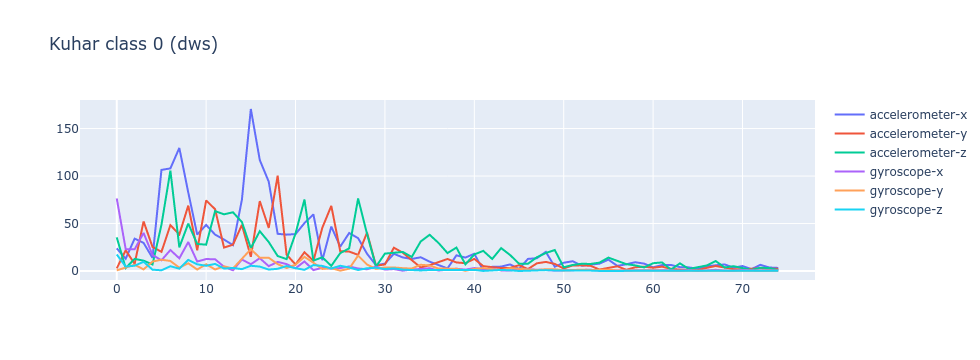

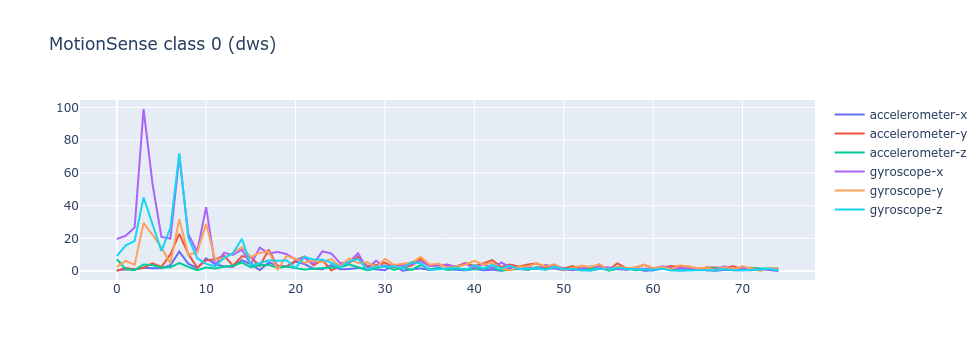

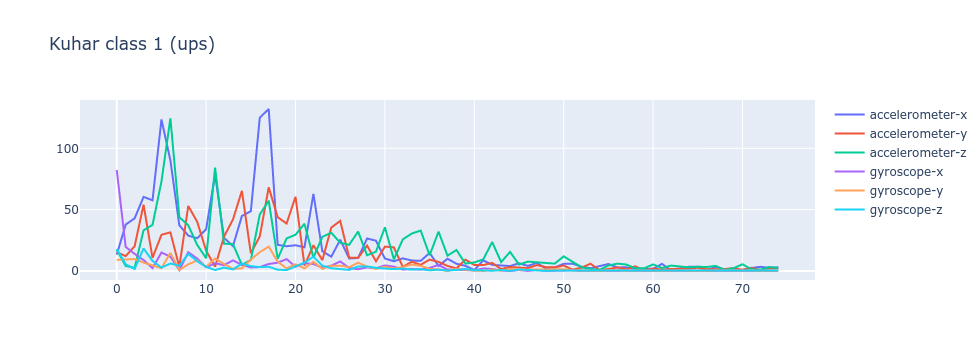

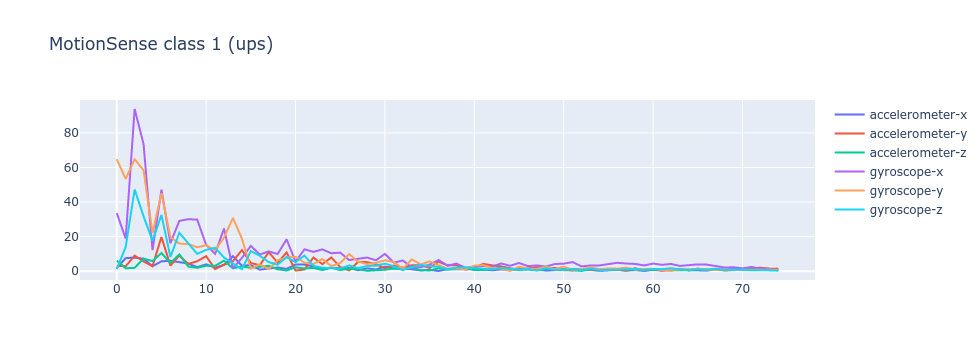

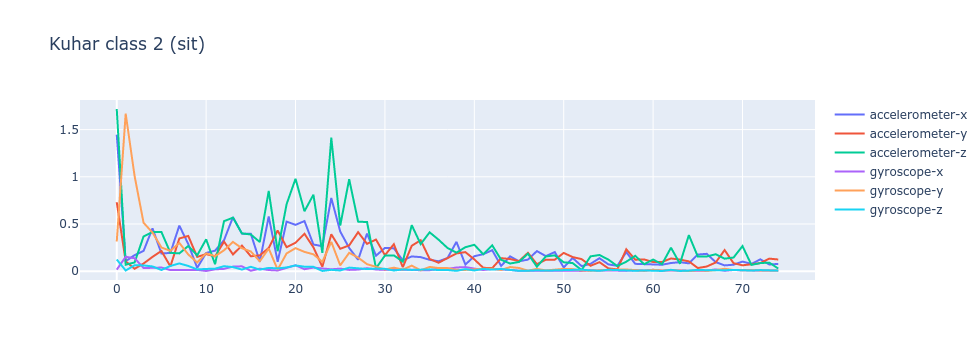

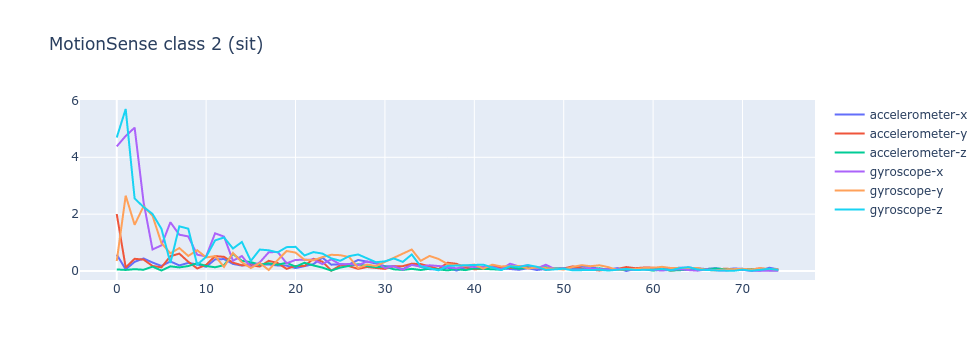

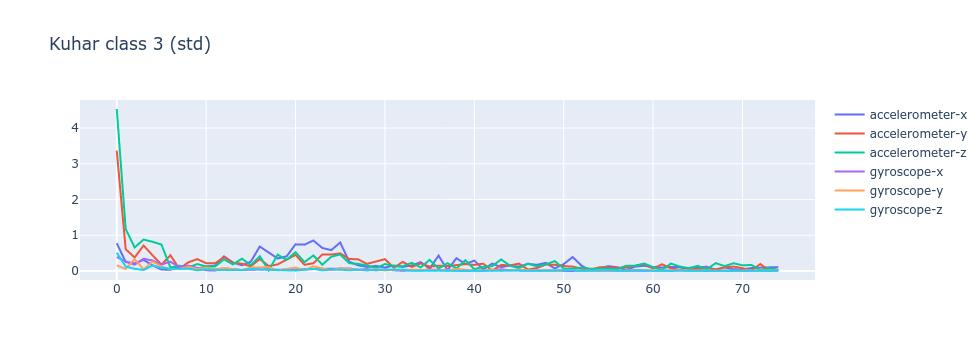

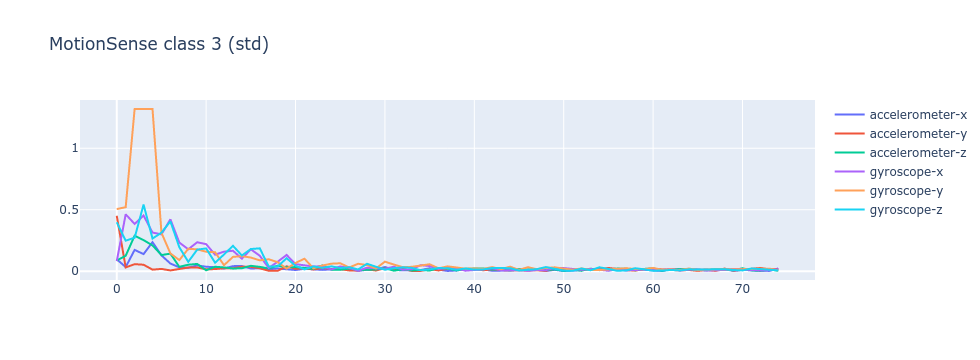

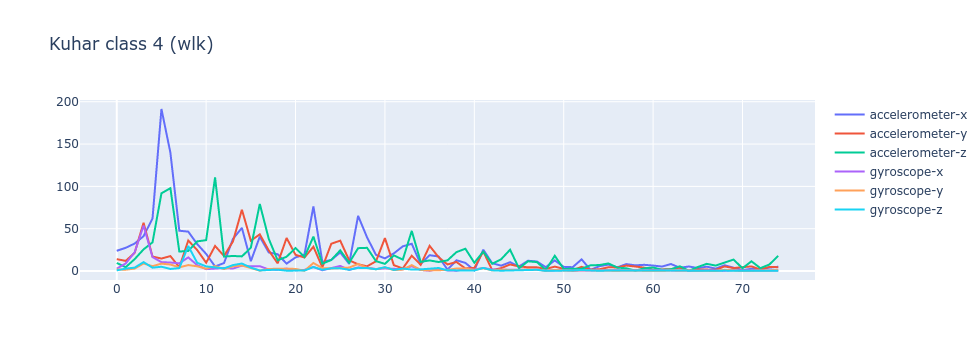

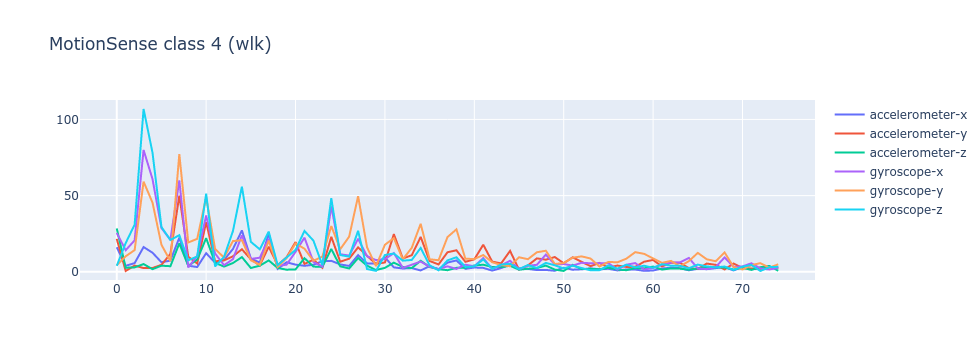

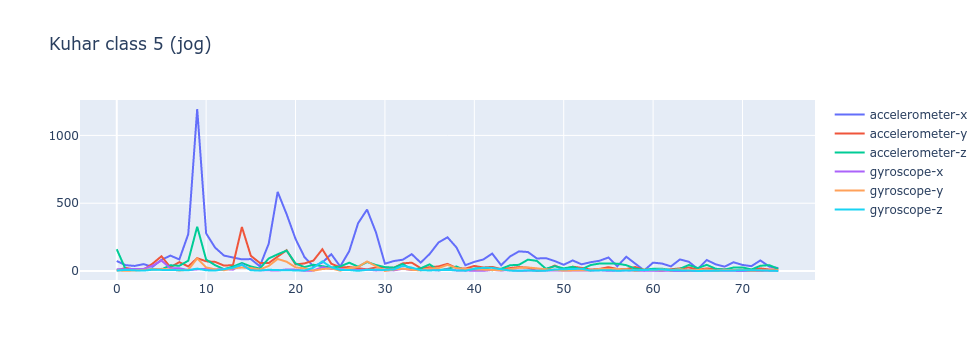

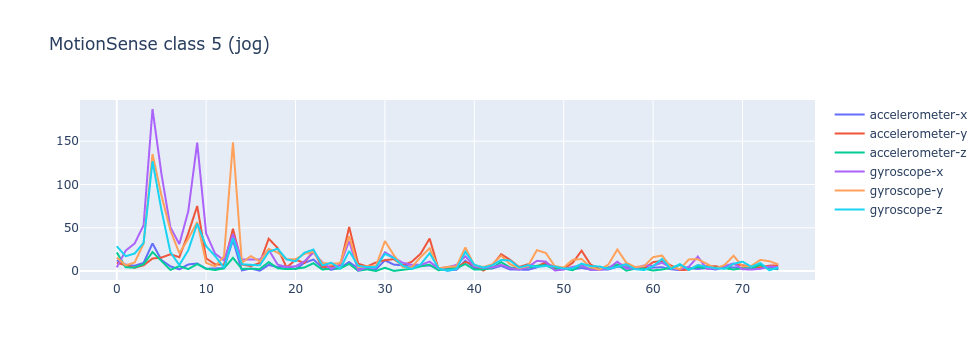

In [13]:
labels = [
    "accelerometer-x",
    "accelerometer-y",
    "accelerometer-z",
    "gyroscope-x",
    "gyroscope-y",
    "gyroscope-z",
]

for act_code, name in activity_names.items():
    kh_sample = select_sample_from_class(
        kh_train_fft_dataset, choosen_class=act_code, shuffle=False, return_index=False
    )
    visualize_sample_windowed(
        window_size=75,
        ys=kh_sample,
        labels=labels,
        title=f"Kuhar class {act_code} ({name})",
    )
    ms_sample = select_sample_from_class(
        ms_train_fft_dataset, choosen_class=act_code, shuffle=False, return_index=False
    )
    visualize_sample_windowed(
        window_size=75,
        ys=ms_sample,
        labels=labels,
        title=f"MotionSense class {act_code} ({name})",
    )

# Train!

In [14]:
def train_and_test(name, model_cls, model_kwargs, train_ds, validation_ds, test_ds, labels: list=None):
    model = model_cls(**model_kwargs)
    print(f" ----- Model {model} at {name} ---------")
    model.fit(train_ds[:][0], train_ds[:][1])
    y_pred = model.predict(test_ds[:][0])
    print(classification_report(test_ds[:][1], y_pred))
    ConfusionMatrixDisplay.from_predictions(test_ds[:][1], y_pred, display_labels=labels)
    print("--------------------\n")

labels = [activity_names[i] for i in range(6)]

In [15]:
ms_datasets = [
    (
        "MotionSense in time",
        ms_train_time_dataset,
        ms_validation_time_dataset,
        ms_test_time_dataset,
    ),
    (
        "MotionSense in FFT",
        ms_train_fft_dataset,
        ms_validation_fft_dataset,
        ms_test_fft_dataset,
    ),
    (
        "MotionSense stats time",
        ms_train_time_stats_dataset,
        ms_validation_time_stats_dataset,
        ms_test_time_stats_dataset,
    ),
    (
        "MotionSense stats FFT",
        ms_train_fft_stats_dataset,
        ms_validation_fft_stats_dataset,
        ms_test_fft_stats_dataset,
    ),
]

 ----- Model RandomForestClassifier() at MotionSense in time ---------
              precision    recall  f1-score   support

           0       0.70      0.83      0.76       169
           1       0.84      0.76      0.80       169
           2       0.97      0.73      0.83       169
           3       0.78      0.97      0.87       169
           4       0.74      0.65      0.69       169
           5       0.94      0.98      0.96       169

    accuracy                           0.82      1014
   macro avg       0.83      0.82      0.82      1014
weighted avg       0.83      0.82      0.82      1014

--------------------

 ----- Model RandomForestClassifier() at MotionSense in FFT ---------
              precision    recall  f1-score   support

           0       0.62      0.88      0.73       169
           1       0.77      0.72      0.74       169
           2       0.98      0.88      0.93       169
           3       0.89      0.98      0.93       169
           4       0.89

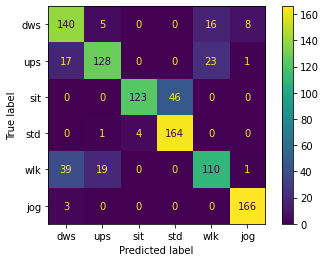

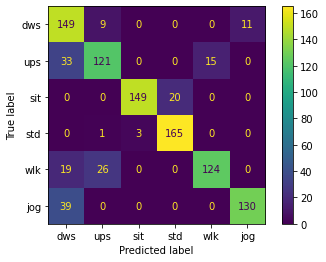

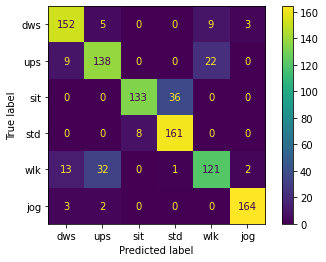

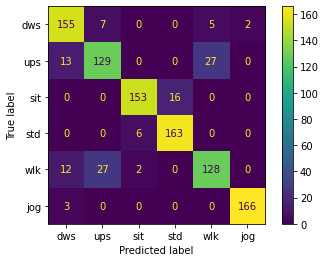

In [16]:
for name, train_ds, val_ds, test_ds in ms_datasets:
    train_and_test(
        name, RandomForestClassifier, {}, train_ds, val_ds, test_ds, labels=labels
    )

In [17]:
kh_datasets = [
    (
        "KuHar in time",
        kh_train_time_dataset,
        kh_validation_time_dataset,
        kh_test_time_dataset,
    ),
    (
        "KuHar in FFT",
        kh_train_fft_dataset,
        kh_validation_fft_dataset,
        kh_test_fft_dataset,
    ),
    (
        "KuHar stats time",
        kh_train_time_stats_dataset,
        kh_validation_time_stats_dataset,
        kh_test_time_stats_dataset,
    ),
    (
        "KuHar stats FFT",
        kh_train_fft_stats_dataset,
        kh_validation_fft_stats_dataset,
        kh_test_fft_stats_dataset,
    ),
]

 ----- Model RandomForestClassifier() at KuHar in time ---------
              precision    recall  f1-score   support

           0       0.39      0.41      0.40       104
           1       0.36      0.30      0.32       104
           2       0.87      0.79      0.83       104
           3       0.81      0.88      0.84       104
           4       0.68      0.95      0.80       104
           5       0.96      0.68      0.80       104

    accuracy                           0.67       624
   macro avg       0.68      0.67      0.66       624
weighted avg       0.68      0.67      0.66       624

--------------------

 ----- Model RandomForestClassifier() at KuHar in FFT ---------
              precision    recall  f1-score   support

           0       0.88      0.43      0.58       104
           1       0.64      0.82      0.72       104
           2       0.89      0.80      0.84       104
           3       0.82      0.90      0.86       104
           4       0.77      0.98  

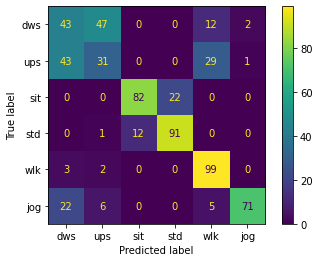

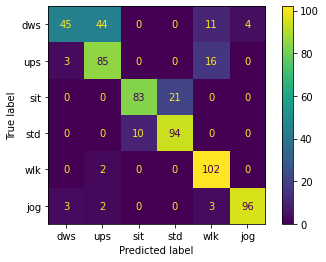

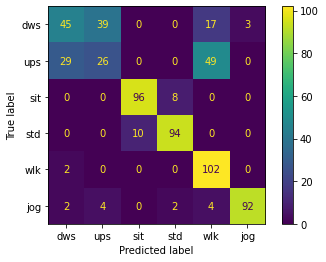

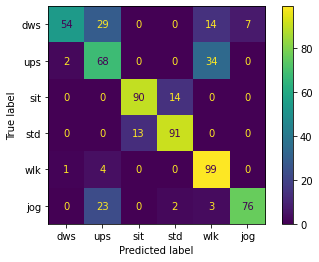

In [18]:
for name, train_ds, val_ds, test_ds in kh_datasets:
    train_and_test(
        name, RandomForestClassifier, {}, train_ds, val_ds, test_ds, labels=labels
    )

In [19]:
mixed_datasets = [
    (
        "KuHar in time (train) / MotionSense in time (test)",
        kh_train_time_dataset,
        kh_validation_time_dataset,
        ms_test_time_dataset,
    ),
    (
        "KuHar in FFT (train) / MotionSense in FFT (test)",
        kh_train_fft_dataset,
        kh_validation_fft_dataset,
        ms_test_fft_dataset,
    ),
    (
        "KuHar stats time (train) / MotionSense in FFT (test)",
        kh_train_time_stats_dataset,
        kh_validation_time_stats_dataset,
        ms_test_time_stats_dataset,
    ),
    (
        "KuHar stats FFT (train) / MotionSense stats FFT (test)",
        kh_train_fft_stats_dataset,
        kh_validation_fft_stats_dataset,
        ms_test_fft_stats_dataset,
    ),


    (
        "MotionSense in time (train) / Kuhar in time (test)",
        ms_train_time_dataset,
        ms_validation_time_dataset,
        kh_test_time_dataset,
    ),
    (
        "MotionSense in FFT (train) / Kuhar in FFT (test)",
        ms_train_fft_dataset,
        ms_validation_fft_dataset,
        kh_test_fft_dataset,
    ),
    (
        "MotionSense stats time (train) / Kuhar in FFT (test)",
        ms_train_time_stats_dataset,
        ms_validation_time_stats_dataset,
        kh_test_time_stats_dataset,
    ),
    (
        "MotionSense stats FFT (train) / Kuhar stats FFT (test)",
        ms_train_fft_stats_dataset,
        ms_validation_fft_stats_dataset,
        kh_test_fft_stats_dataset,
    ),
]

 ----- Model RandomForestClassifier() at KuHar in time (train) / MotionSense in time (test) ---------
              precision    recall  f1-score   support

           0       0.30      0.38      0.34       169
           1       0.28      0.28      0.28       169
           2       0.86      0.07      0.13       169
           3       0.47      0.82      0.60       169
           4       0.37      0.64      0.47       169
           5       0.77      0.14      0.23       169

    accuracy                           0.39      1014
   macro avg       0.51      0.39      0.34      1014
weighted avg       0.51      0.39      0.34      1014

--------------------

 ----- Model RandomForestClassifier() at KuHar in FFT (train) / MotionSense in FFT (test) ---------
              precision    recall  f1-score   support

           0       0.20      0.26      0.22       169
           1       0.42      0.24      0.31       169
           2       0.69      0.74      0.72       169
           3    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.32      0.04      0.06       169
           1       0.14      0.27      0.19       169
           2       0.46      0.71      0.56       169
           3       0.07      0.15      0.09       169
           4       0.26      0.03      0.05       169
           5       0.00      0.00      0.00       169

    accuracy                           0.20      1014
   macro avg       0.21      0.20      0.16      1014
weighted avg       0.21      0.20      0.16      1014

--------------------

 ----- Model RandomForestClassifier() at MotionSense in time (train) / Kuhar in time (test) ---------


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.23      0.10      0.14       104
           1       0.00      0.00      0.00       104
           2       0.43      0.38      0.41       104
           3       0.45      0.50      0.47       104
           4       0.24      0.10      0.14       104
           5       0.30      0.95      0.45       104

    accuracy                           0.34       624
   macro avg       0.28      0.34      0.27       624
weighted avg       0.28      0.34      0.27       624

--------------------

 ----- Model RandomForestClassifier() at MotionSense in FFT (train) / Kuhar in FFT (test) ---------
              precision    recall  f1-score   support

           0       0.11      0.15      0.13       104
           1       0.72      0.20      0.32       104
           2       0.40      0.55      0.46       104
           3       0.29      0.18      0.22       104
           4       0.40      0.02      0.04       104
          

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.00      0.00      0.00       104
           1       0.00      0.00      0.00       104
           2       0.46      0.84      0.59       104
           3       0.00      0.00      0.00       104
           4       0.00      0.00      0.00       104
           5       0.24      0.96      0.39       104

    accuracy                           0.30       624
   macro avg       0.12      0.30      0.16       624
weighted avg       0.12      0.30      0.16       624

--------------------

 ----- Model RandomForestClassifier() at MotionSense stats FFT (train) / Kuhar stats FFT (test) ---------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       104
           1       0.00      0.00      0.00       104
           2       0.43      0.67      0.52       104
           3       0.28      0.12      0.17       104
           4       0.09      0.04      0.05       104
    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



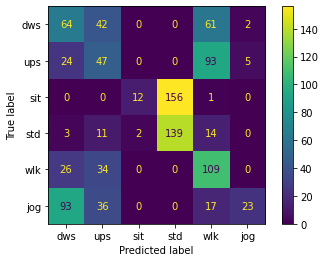

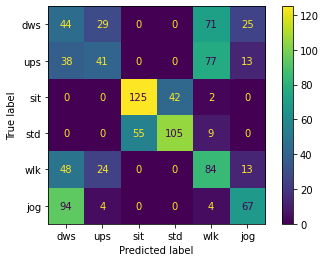

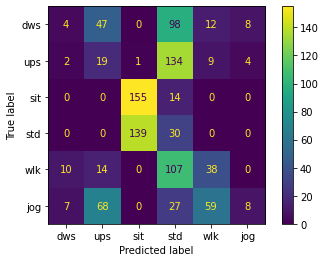

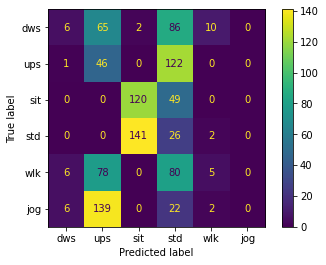

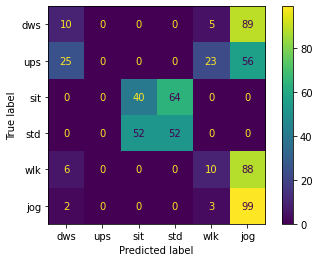

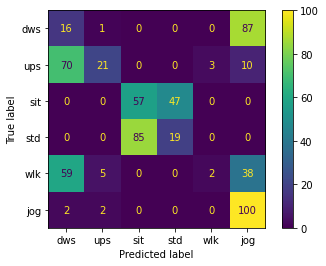

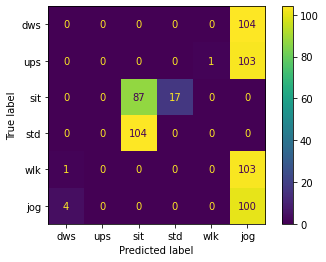

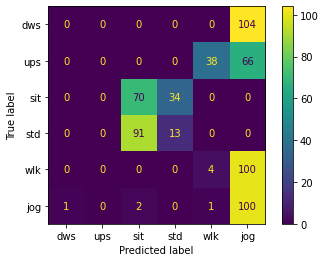

In [20]:
for name, train_ds, val_ds, test_ds in mixed_datasets:
    train_and_test(
        name, RandomForestClassifier, {}, train_ds, val_ds, test_ds, labels=labels
    )

# Feature fusion

In [92]:
def train_and_test_mixed(
    name,
    model_cls,
    model_kwargs,
    train_ds: list,
    validation_ds: list,
    test_ds: list,
    labels: list = None,
):
    train_X = np.concatenate([ds[:][0] for ds in train_ds], axis=1)
    train_y = np.array(train_ds[0][:][1])
    
    test_X = np.concatenate([ds[:][0] for ds in test_ds], axis=1)
    test_y = np.array(test_ds[0][:][1])
    
    model = model_cls(**model_kwargs)
    print(f" ----- Model {model} at {name} ---------")
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    print(classification_report(test_y, y_pred))
    ConfusionMatrixDisplay.from_predictions(
        test_y, y_pred, display_labels=labels
    )
    print("--------------------\n")

In [93]:
mixed_kh_datasets = [
    (
        "KuHar in time + Time stats",
        [kh_train_time_dataset, kh_train_time_stats_dataset],
        [kh_validation_time_dataset, kh_validation_time_stats_dataset],
        [kh_test_time_dataset, kh_test_time_stats_dataset],
    ),
    (
        "KuHar in FFT + FFT stats",
        [kh_train_fft_dataset, kh_train_fft_stats_dataset],
        [kh_validation_fft_dataset, kh_validation_fft_stats_dataset],
        [kh_test_fft_dataset, kh_test_fft_stats_dataset],
    ),
    (
        "KuHar in time stats + FFT stats",
        [kh_train_fft_stats_dataset, kh_train_time_stats_dataset],
        [kh_validation_fft_stats_dataset, kh_validation_time_stats_dataset],
        [kh_test_fft_stats_dataset, kh_test_time_stats_dataset],
    ),

    (
        "KuHar all",
        [kh_train_time_dataset, kh_train_fft_dataset, kh_train_fft_stats_dataset, kh_train_time_stats_dataset],
        [kh_validation_time_dataset, kh_validation_fft_dataset, kh_validation_fft_stats_dataset, kh_validation_time_stats_dataset],
        [kh_test_time_dataset, kh_test_fft_dataset, kh_test_fft_stats_dataset, kh_test_time_stats_dataset],
    )
]

 ----- Model RandomForestClassifier() at KuHar in time + Time stats ---------
              precision    recall  f1-score   support

           0       0.55      0.45      0.49       104
           1       0.39      0.26      0.31       104
           2       0.88      0.83      0.85       104
           3       0.84      0.90      0.87       104
           4       0.62      0.99      0.77       104
           5       1.00      0.89      0.94       104

    accuracy                           0.72       624
   macro avg       0.71      0.72      0.71       624
weighted avg       0.71      0.72      0.71       624

--------------------

 ----- Model RandomForestClassifier() at KuHar in FFT + FFT stats ---------
              precision    recall  f1-score   support

           0       0.94      0.45      0.61       104
           1       0.59      0.67      0.63       104
           2       0.87      0.84      0.85       104
           3       0.84      0.88      0.86       104
          

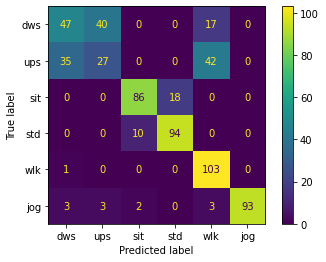

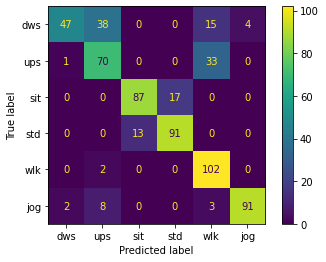

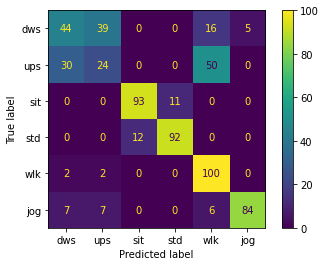

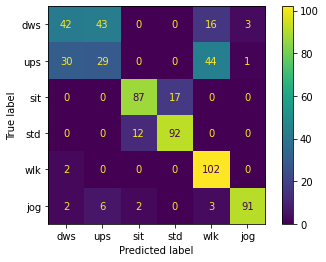

In [94]:
for name, train_ds, val_ds, test_ds in mixed_kh_datasets:
    train_and_test_mixed(
        name, RandomForestClassifier, {}, train_ds, val_ds, test_ds, labels=labels
    )

In [95]:
mixed_ms_datasets = [
    (
        "MotionSense in time + Time stats",
        [ms_train_time_dataset, ms_train_time_stats_dataset],
        [ms_validation_time_dataset, ms_validation_time_stats_dataset],
        [ms_test_time_dataset, ms_test_time_stats_dataset],
    ),
    (
        "MotionSense in FFT + FFT stats",
        [ms_train_fft_dataset, ms_train_fft_stats_dataset],
        [ms_validation_fft_dataset, ms_validation_fft_stats_dataset],
        [ms_test_fft_dataset, ms_test_fft_stats_dataset],
    ),
    (
        "MotionSense in time stats + FFT stats",
        [ms_train_fft_stats_dataset, ms_train_time_stats_dataset],
        [ms_validation_fft_stats_dataset, ms_validation_time_stats_dataset],
        [ms_test_fft_stats_dataset, ms_test_time_stats_dataset],
    ),

    (
        "MotionSense all",
        [ms_train_time_dataset, ms_train_fft_dataset, ms_train_fft_stats_dataset, ms_train_time_stats_dataset],
        [ms_validation_time_dataset, ms_validation_fft_dataset, ms_validation_fft_stats_dataset, ms_validation_time_stats_dataset],
        [ms_test_time_dataset, ms_test_fft_dataset, ms_test_fft_stats_dataset, ms_test_time_stats_dataset],
    )
]

 ----- Model RandomForestClassifier() at MotionSense in time + Time stats ---------
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       169
           1       0.77      0.70      0.73       169
           2       0.95      0.80      0.87       169
           3       0.83      0.96      0.89       169
           4       0.70      0.66      0.68       169
           5       0.87      0.96      0.91       169

    accuracy                           0.82      1014
   macro avg       0.82      0.82      0.81      1014
weighted avg       0.82      0.82      0.81      1014

--------------------

 ----- Model RandomForestClassifier() at MotionSense in FFT + FFT stats ---------
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       169
           1       0.78      0.79      0.79       169
           2       0.97      0.90      0.94       169
           3       0.90      0.98      0.93       16

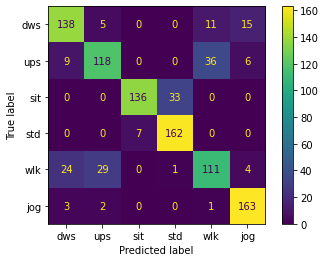

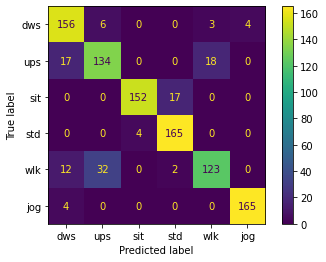

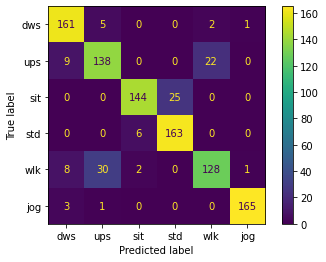

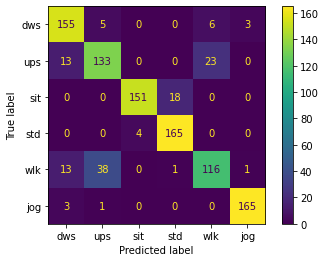

In [96]:
for name, train_ds, val_ds, test_ds in mixed_ms_datasets:
    train_and_test_mixed(
        name, RandomForestClassifier, {}, train_ds, val_ds, test_ds, labels=labels
    )

In [97]:
len(kh_train_dataset), len(ms_train_dataset)

(1386, 3318)